In [23]:
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.filters.rank import entropy
from skimage.morphology import disk
from scipy.ndimage import binary_fill_holes, binary_dilation, binary_erosion
from skimage.morphology import remove_small_objects
from skimage import filters, io, measure

In [2]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)

    else:
        r = width / float(w)
        dim = (width, int(h * r))

    resized = cv2.resize(image, dim, interpolation = inter)
    return resized

In [39]:
orig_img = cv2.imread("./data/res.jpg")
orig_h, orig_w = orig_img.shape[:2]
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = image_resize(orig_img, height=512)

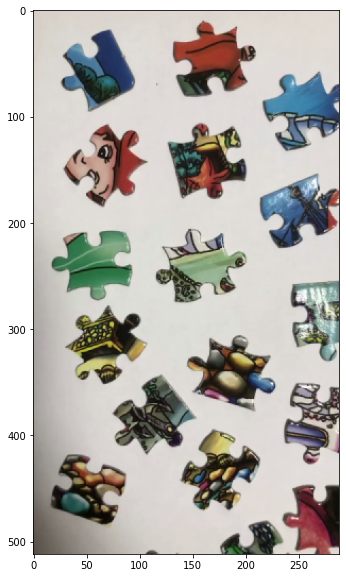

In [40]:
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [41]:
def count_number_of_objects(mask):    
    drops = binary_fill_holes(mask*255 > 0.0001)    
    labels = measure.label(drops)    
    return labels.max()

def morphology_postprocess(mask: np.ndarray, min_size=0):
    mask = binary_fill_holes(mask, structure=np.ones((3, 3)))
    if min_size > 0:
        mask = remove_small_objects(mask, min_size)
    return mask.astype(np.uint8)

def enhance_mask(mask: np.ndarray) -> np.ndarray:
    mask = mask.astype(np.uint8)
    dilated = binary_dilation(mask, structure=np.ones((1, 1), dtype=np.bool))
    dilated = binary_fill_holes(dilated)
    return dilated.astype(np.uint8)

In [42]:
# gray   = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# gray   = cv2.medianBlur(gray, ksize=3)
# thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)[1]
# thresh = cv2.blur(thresh, ksize=(3, 3))

# size_ratio = 0.25
# min_size = img.size / (size_ratio * 100) ** 2
# mask = morphology_postprocess(mask=thresh, min_size=min_size)
# # mask = enhance_mask(thresh)

# print(count_number_of_objects(mask))

# plt.figure(figsize=(15, 10))
# plt.imshow(mask, cmap="gray")
# plt.show()

19.6608


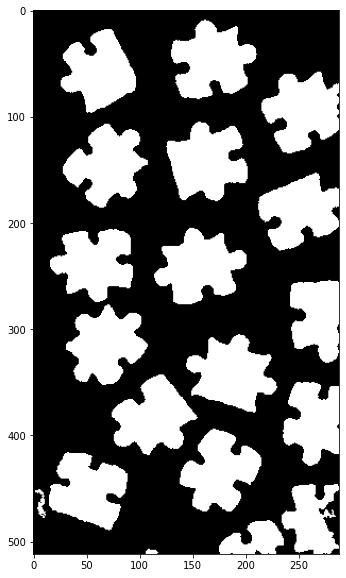

In [43]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
entropy_img = entropy(gray, disk(3))
scaled_entropy = entropy_img / entropy_img.max()

thresh = scaled_entropy > 0.72

size_ratio = 1.5
min_size = img.size / (size_ratio * 100) ** 2
print(min_size)
mask = morphology_postprocess(thresh, min_size)

plt.figure(figsize=(15, 10))
plt.imshow(mask, cmap="gray")
plt.show()

In [44]:
def find_polygons(mask, n_poly=2, min_area=2200):
    contours,_ = cv2.findContours(mask.astype(np.uint8).copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    sorted_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:n_poly]
    
    approxes = []
    for cnt in sorted_contours:
        area = cv2.contourArea(cnt)
        if area > min_area:
            approxes += [cv2.approxPolyDP(cnt, 0.001 * cv2.arcLength(cnt, True), True)]

    return approxes


def draw_transarent_polygons(image, mask, polygons, alpha=0.4):
    poly_img = image.copy()
    out_img = image.copy()
    
    cv2.fillPoly(poly_img, pts=polygons, color=(0, 255, 0))
    out_img = cv2.addWeighted(poly_img, alpha, out_img, 1 - alpha, 0)
        
    new_mask = np.zeros(mask.shape[:2])
    cv2.fillPoly(new_mask, pts=polygons, color=(255,255,255))
    return out_img, new_mask

In [45]:
def distance(x1, x2):
    dist_array = (x1[0]-x2[0])**2 + (x1[1]-x2[1])**2
    return np.sum(np.sqrt(dist_array)) 


def find_marginal_puzzles(polygons, max_vertex_dist = 50):
    marginal_puzzles = []
    corner_puzzles = []
    
    for polygon in polygons:
        polygon = cv2.approxPolyDP(polygon, 0.02 * cv2.arcLength(polygon, True), True)
        overlayed_image, _ = draw_transarent_polygons(img, mask, [polygon])

        for v1, v2 in zip(polygon, np.roll(polygon, 1, axis=0)):
            side_counter = 0
            if distance(v1[0], v2[0]) > max_vertex_dist:

                if side_counter > 0:
                    corner_puzzles.append(polygon)
                else:
                    marginal_puzzles.append(polygon)
                    side_counter += 1
                break
                
    return marginal_puzzles, corner_puzzles


def check_corner_puzzle():
    ...
    

def check_marginal_puzzle():
    ...
    
    
def remove_frame_edge_puzzles(polygons, w, h):
    inner_polygons = []
    
    for i, polygon in enumerate(polygons):
        x_coords = polygons[i][:, 0, 0]
        y_coords = polygons[i][:, 0, 1]

        if any(x_coords == 0) or any(x_coords == w - 1) or any(y_coords == 0) or any(y_coords == h - 1):
            pass
        else:
            inner_polygons.append(polygon)
            
    return inner_polygons

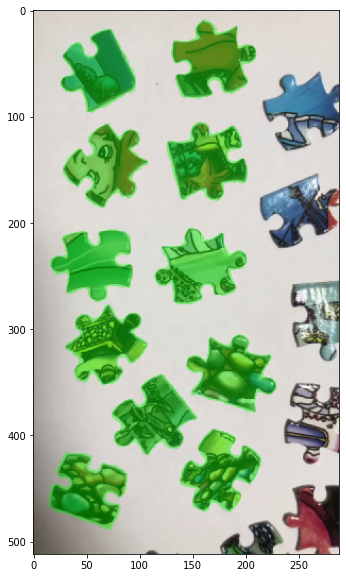

In [46]:
height, width = img.shape[:2]

polygons = find_polygons(mask, n_poly=-1, min_area=500)
inner_polygons = remove_frame_edge_puzzles(polygons, width, height)
overlayed_image, _ = draw_transarent_polygons(img, mask, inner_polygons)

cv2.imwrite("data/frame.jpg", overlayed_image)
plt.figure(figsize=(15, 10))
plt.imshow(overlayed_image)
plt.show()

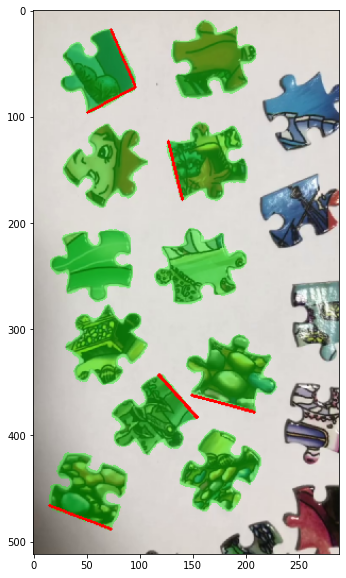

In [47]:
marginal_puzzles, corner_puzzles = find_marginal_puzzles(inner_polygons)

for shape in marginal_puzzles:
    for v1, v2 in zip(shape, np.roll(shape, 1, axis=0)):
        if distance(v1[0], v2[0]) > 50:
            cv2.line(overlayed_image, v1[0], v2[0], (255, 0, 0), 2)

plt.figure(figsize=(15, 10))
plt.imshow(overlayed_image)
plt.show()

In [48]:
pic = cv2.imread("data/photo5204139026079135811.jpg")
pic = cv2.cvtColor(pic, cv2.COLOR_BGR2RGB)

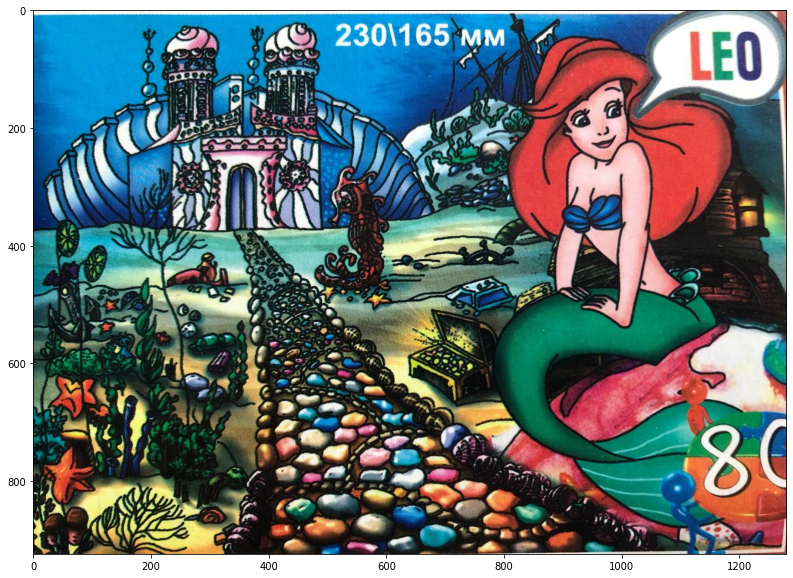

In [49]:
plt.figure(figsize=(15, 10))
plt.imshow(pic)
plt.show()

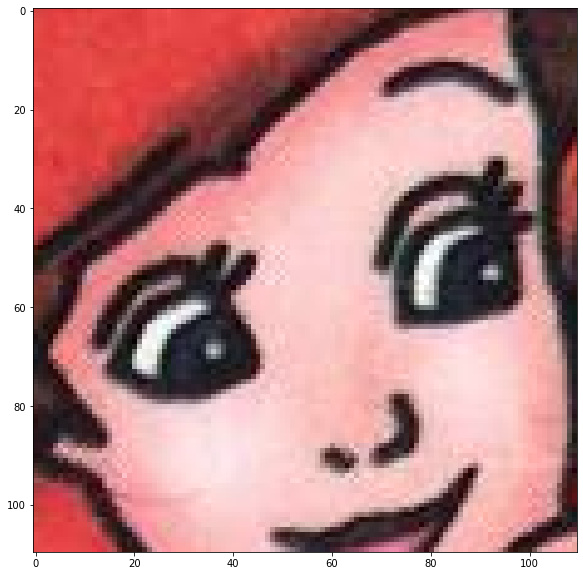

In [50]:
tile = pic[120:230, 900:1010, :]

cv2.imwrite("data/tile.jpg", tile)
plt.figure(figsize=(15, 10))
plt.imshow(tile)
plt.show()

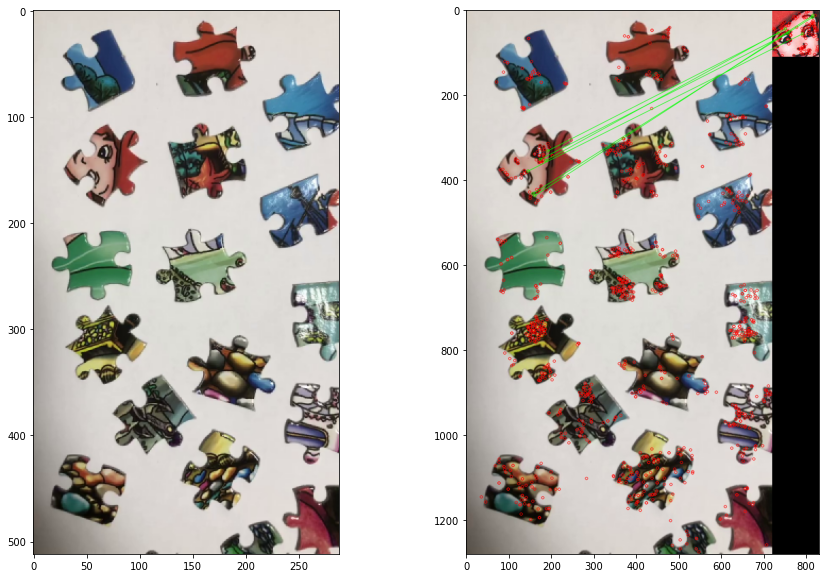

In [52]:
img1 = orig_img.copy()
img2 = tile.copy()

mask1 = mask.copy()
mask1 = binary_erosion(mask1, structure=np.ones((5, 5)))
mask1 = mask1.astype(np.uint8)

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, mask1)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.5*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv2.DrawMatchesFlags_DEFAULT)
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(img3)
plt.show()

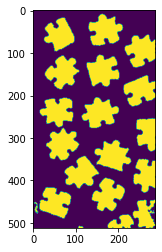

In [17]:
plt.imshow(mask)
plt.show()

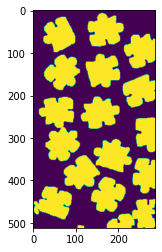

In [22]:
mask1 = mask.copy()
mask1 = binary_dilation(mask1, structure=np.ones((5, 5)))
mask1 = mask1.astype(np.uint8)
plt.imshow(mask1)
plt.show()

In [28]:
matches

((<DMatch 0x7f16a012e190>, <DMatch 0x7f16561e9f70>),
 (<DMatch 0x7f16561e9ed0>, <DMatch 0x7f167c1edd30>),
 (<DMatch 0x7f16564e2c30>, <DMatch 0x7f16506e7710>),
 (<DMatch 0x7f16506e7ab0>, <DMatch 0x7f16506e7a90>),
 (<DMatch 0x7f16506e7d90>, <DMatch 0x7f16506e7330>),
 (<DMatch 0x7f16506e7370>, <DMatch 0x7f16506e7c70>),
 (<DMatch 0x7f16506e7d50>, <DMatch 0x7f16506e7f10>),
 (<DMatch 0x7f16a00eb910>, <DMatch 0x7f16a00eb6b0>),
 (<DMatch 0x7f16a00ebaf0>, <DMatch 0x7f16a00ebad0>),
 (<DMatch 0x7f16a00eb970>, <DMatch 0x7f16a00ebb70>),
 (<DMatch 0x7f16a00eb650>, <DMatch 0x7f16a00eba10>),
 (<DMatch 0x7f16a00ebb10>, <DMatch 0x7f16a00eb410>),
 (<DMatch 0x7f16507508d0>, <DMatch 0x7f1650750fb0>),
 (<DMatch 0x7f1650750d50>, <DMatch 0x7f167c266030>),
 (<DMatch 0x7f167c266050>, <DMatch 0x7f167c266070>),
 (<DMatch 0x7f167c266090>, <DMatch 0x7f167c2660b0>),
 (<DMatch 0x7f167c2660d0>, <DMatch 0x7f167c2660f0>),
 (<DMatch 0x7f167c266110>, <DMatch 0x7f167c266130>),
 (<DMatch 0x7f167c266150>, <DMatch 0x7f167c266